## Implementing local gauge invariance with atomic mixtures.

This Notebook is based on the following [paper](https://science.sciencemag.org/content/367/6482/1128), which was performed on the NaLi machine at SynQS. In this paper a new scalable analog quantum simulator of a U(1) gauge theory is demonstrated. 

By using interspecies spin-changing collisions between particles, a gauge-invariant interaction between matter and gauge-field is achieved. In this case an atomic mixture of sodium and lithium is used.

We will model the system with two qudits of slightly different length. The first qudit is the matter field and the second qudit the gauge field.



In [1]:
import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pennylane_ls import *
from heroku_credentials import username, password

# Rotating the matter field

we have to rotate the matter field to initialize the dynamics in the system first

In [3]:
NaLiDevice = qml.device("synqs.mqs",wires=2,shots=50, username = username, password = password)

In [4]:
@qml.qnode(NaLiDevice)
def matterpreparation(alpha=0):
    MultiQuditOps.load(2,wires=[0])
    MultiQuditOps.load(20,wires=[1])
    MultiQuditOps.rLx(alpha,wires=[1])
    obs = MultiQuditOps.Lz(0) @ MultiQuditOps.Lz(1)
    return qml.expval(obs)

visualize the circuit

In [5]:
matterpreparation(np.pi)
print(matterpreparation.draw())

 0: ──load(2)──────────────╭┤ ⟨Lz ⊗ Lz⟩ 
 1: ──load(20)──rLx(3.14)──╰┤ ⟨Lz ⊗ Lz⟩ 



now reproduce figure 1

In [6]:
alphas = np.linspace(0, np.pi, 15)
means = np.zeros((len(alphas),2))
for i in range(len(alphas)):
    if i%10==0:
        print("step", i)
    # Calculate the resulting states after each rotation
    means[i,:] = matterpreparation(alphas[i])

step 0
step 10


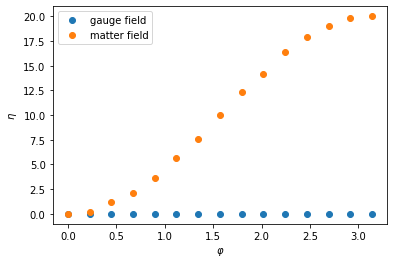

In [7]:
f, ax = plt.subplots()
ax.plot(alphas, means[:,0], 'o', label = 'gauge field')
ax.plot(alphas, means[:,1], 'o', label = 'matter field')
ax.set_ylabel(r'$\eta$')
ax.set_xlabel(r'$\varphi$')
ax.legend()

## time evolution
and now a time evolution

In [8]:
@qml.qnode(NaLiDevice)
def t_evolv(alpha=0, beta=0, gamma=0, delta=0, NLi = 1, NNa = 10, Ntrott = 1):
    '''Circuit that describes the time evolution.
    
    alpha ... Initial angle of rotation of the matter field
    beta ... Angle of rotation for the matter field
    gamma ... Angle of rotation on the squeezing term.
    delta ... Angle of rotation of the flip flop term.
    '''
    # preparation step
    MultiQuditOps.load(NLi,wires=[0])
    MultiQuditOps.load(NNa,wires=[1])
    MultiQuditOps.rLx(alpha,wires=[1])
    
    # time evolution
    for ii in range(Ntrott):
        MultiQuditOps.LxLy(delta/Ntrott,wires=[0,1])
        MultiQuditOps.rLz(beta/Ntrott,wires=[0])
        MultiQuditOps.rLz2(gamma/Ntrott,wires=[1])
    obs = MultiQuditOps.Lz(0)
    return qml.expval(obs)

In [9]:
t_evolv(alpha=np.pi/2, beta=0.1, gamma=0.3, delta=0.2)

tensor(0.78, requires_grad=False)

In [10]:
print(t_evolv.draw())

 0: ──load(1)──────────────╭LxLy(0.2)──rLz(0.1)───┤ ⟨Lz⟩ 
 1: ──load(10)──rLx(1.57)──╰LxLy(0.2)──rLz2(0.3)──┤      



parameters of the experiment

In [11]:
Delta = -2*np.pi*500;
chiT = 2.*np.pi*0.01*300e3;
lamT = 2.*np.pi*2e-4*300e3;

In [12]:
Ntrott = 4;
NLi = 3;
NNa = 50;
alpha = np.pi/2;
chi = chiT/NNa;
lam = lamT/NNa;

In [ ]:
times = np.linspace(0, 10., 5)*1e-3;
means = np.zeros(len(times))
for i in range(len(times)):
    means[i] = t_evolv(alpha, Delta*times[i], chi*times[i],lam*times[i], NLi, NNa, Ntrott = Ntrott)

In [ ]:
f, ax = plt.subplots()
ax.plot(times*1e3, means, 'o', label = 'matter field')
ax.set_ylabel(r'$\eta$')
ax.set_xlabel('time (ms)')
ax.legend()